# K-Nearest Neighbors notes

### What is KNN?

Supervised Algorithm

Makes predictions based on how close a new data point is to known data points.

Considered a lazy algorithm in that it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the k nearest neighbours of each point.

Predictions are made for a new data point by searching through the entire training set for the K most similar instances (the neighbors) and summarizing the output variable for those K instances. For regression problems, this might be the mean output variable. For classification problems this might be the mode (or most common) class value.

It is important to define a metric to measure how similar data instances are. Euclidean distance can be used if attributes are all on the same scale (or you convert them to the same scale).

<img src="https://cambridgecoding.files.wordpress.com/2016/01/knn2.jpg" style="height:500px" />

- Pros

    Simple to implement
    
    Robust to noisy training data
    
    Effective if training data is large
    
    Performs calculations "just in time", i.e. when a prediction is needed (as opposed to ahead of time)
    
    Training instances can be updated and curated over time to keep predictions accurate.<br><br>




- Cons

    Need to determine the value of K
    
    The computation cost is high as it needs to compute the distance of each instance to all the training samples...you need to hang on to your entire training dataset.
    
    Distance can break down in very high dimensions, negatively affecting the performance. This is know as the "Curse of dimensionality". To alleviate, only use those input variables that are most relevant to predicting the output variable.

In [3]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from pydataset import data

# read Iris data from pydatset
df = data('iris')

# convert column names to lowercase, replace '.' in column names with '_'
df.columns = [col.lower().replace('.', '_') for col in df]

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


### Train Validate Test

**Now we'll do our train/validate/test split:**

We'll do exploration and train our model on the train data

We tune our model on validate, since it will be out-of-sample until we use it.

And keep the test nice and safe and separate, for our final out-of-sample dataset, to see how well our tuned model performs on new data.

In [4]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [5]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='species', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['species'])
y_train = train.species

X_validate = validate.drop(columns=['species'])
y_validate = validate.species

X_test = test.drop(columns=['species'])
y_test = test.species

## Train Model

### Create KNN Object

In [6]:
# weights = ['uniform', 'distance']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

## Fit the model

### Fit the model to the training data.

In [7]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

## Make Predictions

### Classify each flower by its estimated species.

In [8]:
y_pred = knn.predict(X_train)

## Estimate Probability

### Estimate the probability of each species, using the training data.

In [9]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.99


### Create a confusion matrix

In [10]:
print(confusion_matrix(y_train, y_pred))

[[28  0  0]
 [ 0 27  1]
 [ 0  0 28]]


### Create a classificaiton report

Precision: 
T
P
/
(
T
P
+
F
P
)

Recall: 
T
P
/
(
T
P
+
F
N
)

F1-Score: A measure of accuracy. The harmonic mean of precision & recall. The harmonic mean is the reciprocal of the arithmetic mean of the reciprocals.

F1 
∈
[
0
,
1
]

F1-score = harmonic mean = 
2
/
(
1
/
p
r
e
c
i
s
i
o
n
)
+
(
1
/
r
e
c
a
l
l
)

Support: number of occurrences of each class.




In [11]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        28
  versicolor       1.00      0.96      0.98        28
   virginica       0.97      1.00      0.98        28

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



Let's look at how this works manually and through simple visual classification. We start with 4 labeled samples here.

In [13]:
# first_nearest_neighbor
import pandas as pd
samples = pd.DataFrame({'a': [5.7, 5.5, 6.3], 
                        'b': [2.6, 3.5, 2.8], 
                        'c': [3.5, 1.3, 5.1], 
                        'd': [1.0, 0.2, 1.5], 
                        'target': ['versicolor', 'setosa', 'virginica']
                       })


samples

,a,b,c,d,target
0,5.7,2.6,3.5,1.0,versicolor
1,5.5,3.5,1.3,0.2,setosa
2,6.3,2.8,5.1,1.5,virginica


We then add 3 new unlabeled observations. For each observation, we look to the labeled samples to see which one it is closer to, in order to find the "1st-Nearest Neighbor".

In [14]:
new_obs = pd.DataFrame([[6.3, 2.8, 5.1, 1.4], 
                       [6.25, 2.77, 5.09, 1.35], 
                       [5.5, 3.5, 1.29, 0.3]], 
                        columns = ['a', 'b', 'c', 'd'])

new_obs

,a,b,c,d
0,6.30,2.80,5.10,1.40
1,6.25,2.77,5.09,1.35
2,5.50,3.50,1.29,0.30


It is pretty clear which samples each new observation corresponds to. So we add those predictions.

In [15]:
pred_target = pd.DataFrame(['virginica', 'virginica', 'setosa'], columns=['pred_target'])
pd.concat([new_obs, pred_target], axis=1)

,a,b,c,d,pred_target
0,6.30,2.80,5.10,1.40,virginica
1,6.25,2.77,5.09,1.35,virginica
2,5.50,3.50,1.29,0.30,setosa


This is what K-Nearest Neighbors is doing for us. Except it's using the distance formula to actually compute the distance and find the K sample/labeled observations with the shortest or minimum distances. Of those K samples, which species is most common? i.e. what is the mode of those neighbors?

## Validate Model
### Evaluate on Out-of-Sample data

### Compute the accuracy of the model when run on the validate dataset.

In [16]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.97


## Visualize Model

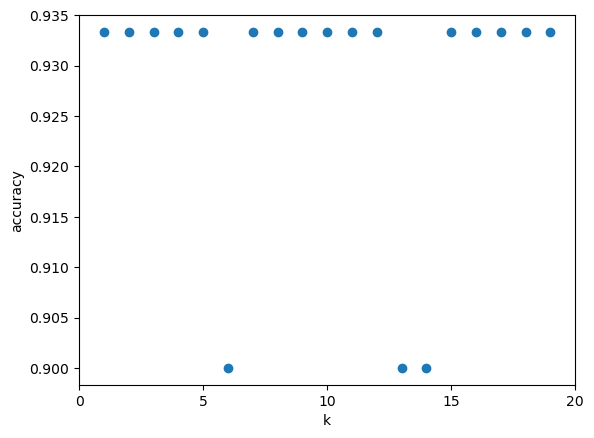

In [17]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()